# Vizualiation of predicitons 

## Predictions of the top performing models according the dominance analysis and scpm ranking

### Random Forest - Top model according to the SCPM of -4.50

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "203",
    "Plant": "C",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/203/c.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

x = x.reset_index(drop=True)
dates = dates.reset_index(drop=True)

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [10]:
repeats = 3
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.970 (0.081)
MAE: -0.736 (0.075)
MAPE: -0.017 (0.002)
R2: 0.973 (0.004)


******
[TEST]
******
RMSE: -1.470 (0.638)
MAE: -1.103 (0.357)
MAPE: -0.025 (0.007)
R2: 0.930 (0.059)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2017-08-01 15:36:00,49.03,47.227802,TRAIN
1,2017-08-02 15:41:00,46.93,47.227802,TRAIN
2,2017-08-02 15:41:00,33.20,34.438321,TRAIN
3,2017-08-04 15:41:00,46.80,47.424124,TRAIN
4,2017-08-04 15:41:00,34.40,34.438321,TRAIN
...,...,...,...,...
2824,2023-03-28 11:01:00,47.19,48.569777,TEST
2825,2023-03-29 11:01:00,33.78,36.035668,TEST
2826,2023-03-29 11:01:00,46.58,45.017921,TEST
2827,2023-03-29 11:01:00,46.28,48.062367,TEST


<IPython.core.display.Javascript object>

In [13]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2017-08-01 15:36:00,49.03,47.227802,TRAIN,1
1,2017-08-02 15:41:00,46.93,47.227802,TRAIN,1
2,2017-08-02 15:41:00,33.20,34.438321,TRAIN,1
3,2017-08-04 15:41:00,46.80,47.424124,TRAIN,1
4,2017-08-04 15:41:00,34.40,34.438321,TRAIN,1
...,...,...,...,...,...
2824,2023-03-28 11:01:00,47.19,48.569777,TEST,5
2825,2023-03-29 11:01:00,33.78,36.035668,TEST,5
2826,2023-03-29 11:01:00,46.58,45.017921,TEST,5
2827,2023-03-29 11:01:00,46.28,48.062367,TEST,5


<IPython.core.display.Javascript object>

In [14]:
(df_pred["SET"] == "TEST").sum()

2355

<IPython.core.display.Javascript object>

In [15]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_random_forest_tsscv_209_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_random_forest_tsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [16]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [17]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,2829.0,43.732124,5.959211,31.53,36.25,46.55,47.83,52.35


<IPython.core.display.Javascript object>

In [18]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_random_forest_tsscv_209_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_random_forest_tsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [19]:
# # Store predictions for each fold
# all_predictions = []

# for idx, pipeline in enumerate(scores["estimator"]):
#     index_train = scores["indices"]["train"][idx]
#     index_test = scores["indices"]["test"][idx]
#     index_preds = np.concatenate([index_train, index_test])

#     results = pipeline.predict(x.loc[index_preds])

#     # Store predictions along with fold information
#     fold_predictions = pd.DataFrame(
#         {
#             "DATE": dates[index_preds],
#             "CS28": y[index_preds],
#             "CS28_PRED": results,
#             "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
#             "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
#         }
#     )
#     all_predictions.append(fold_predictions)

# # Concatenate predictions from all folds
# df_pred = pd.concat(all_predictions)
# df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

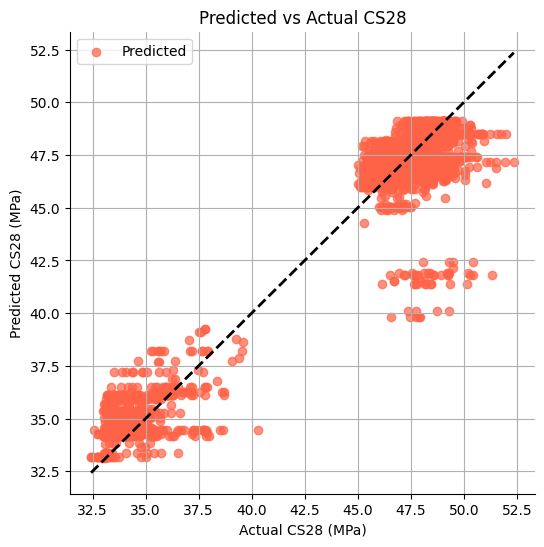

<IPython.core.display.Javascript object>

In [20]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

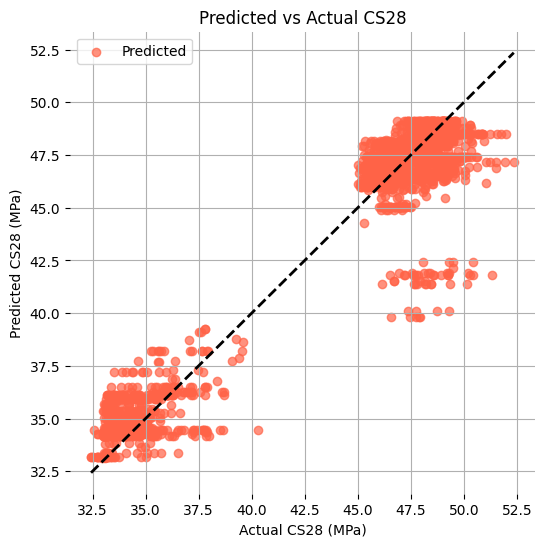

<IPython.core.display.Javascript object>

In [21]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.show()

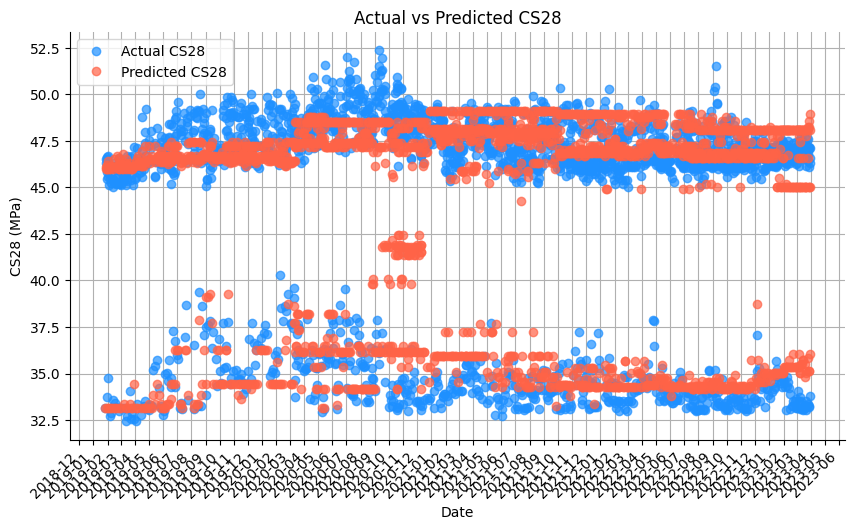

<IPython.core.display.Javascript object>

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


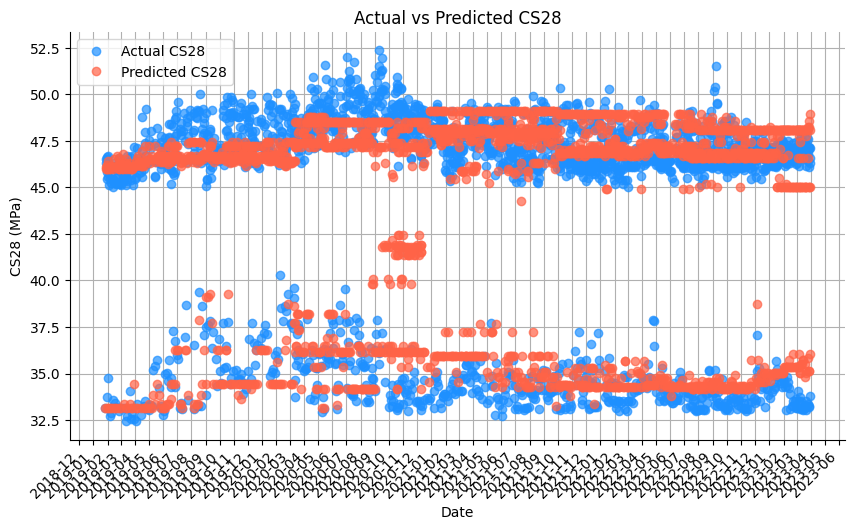

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [24]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [25]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Importances - 0,0.0,0.000000,0.000285,0.002198,0.000519,0.000187,0.0,0.0,0.000164,0.001035,0.000000,0.975276,0.0,0.000000,0.0,0.0,0.000129,0.000009,0.020200
Importances - 1,0.0,0.000000,0.000000,0.000301,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000178,0.773133,0.0,0.000512,0.0,0.0,0.003368,0.001194,0.221315
Importances - 2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001340,0.000000,0.000000,0.195073,0.0,0.000000,0.0,0.0,0.003319,0.203932,0.596336
Importances - 3,0.0,0.001140,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000467,0.001137,0.000573,0.000592,0.0,0.000000,0.0,0.0,0.001285,0.197928,0.796878
Importances - 4,0.0,0.001348,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000836,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.001455,0.196269,0.800092


<IPython.core.display.Javascript object>

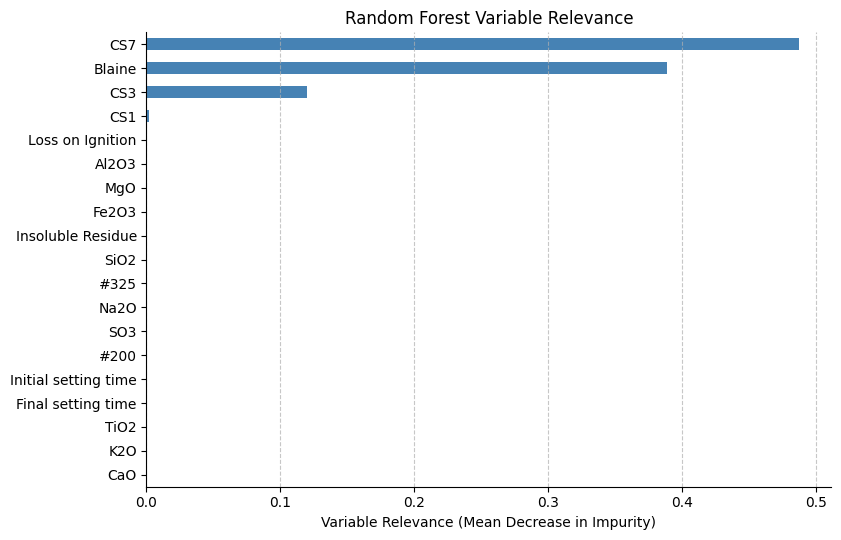

<IPython.core.display.Javascript object>

In [26]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Relevance")
plt.xlabel("Variable Relevance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

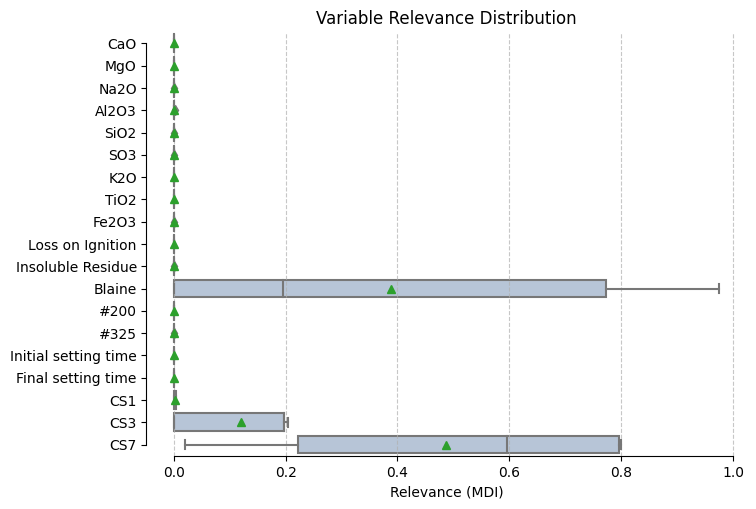

<IPython.core.display.Javascript object>

In [27]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


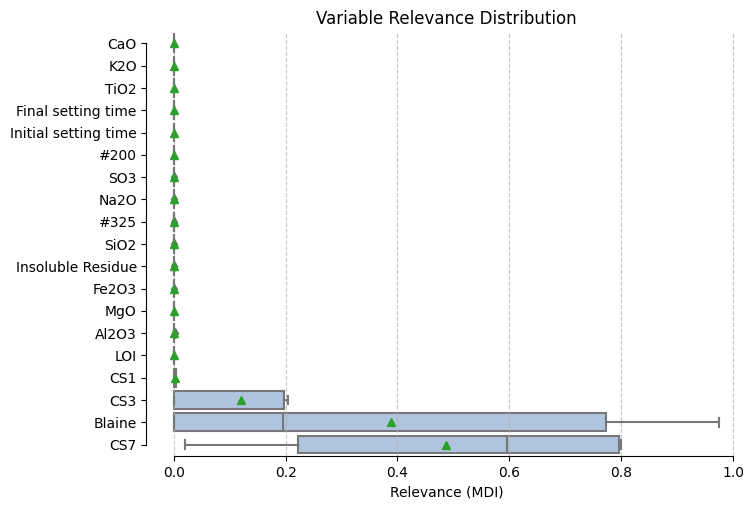

<IPython.core.display.Javascript object>

In [28]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [29]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [30]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

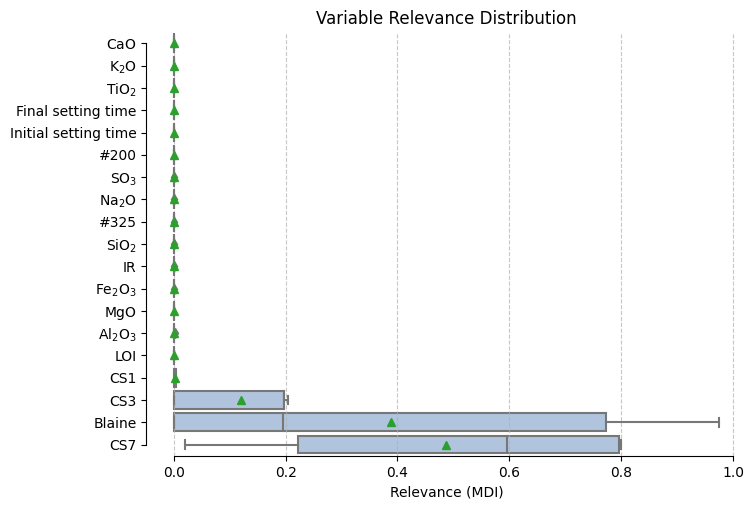

<IPython.core.display.Javascript object>

In [31]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# plt.rcParams.update(
#     {
#         "mathtext.fontset": "custom",
#         "mathtext.rm": "DejaVu Sans",
#         "mathtext.it": "DejaVu Sans:italic",
#         "mathtext.bf": "DejaVu Sans:bold",
#     }
# )


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [32]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Importances - 0,0.0,0.000000,0.000285,0.002198,0.000519,0.000187,0.0,0.0,0.000164,0.001035,0.000000,0.975276,0.0,0.000000,0.0,0.0,0.000129,0.000009,0.020200
Importances - 1,0.0,0.000000,0.000000,0.000301,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000178,0.773133,0.0,0.000512,0.0,0.0,0.003368,0.001194,0.221315
Importances - 2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001340,0.000000,0.000000,0.195073,0.0,0.000000,0.0,0.0,0.003319,0.203932,0.596336
Importances - 3,0.0,0.001140,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000467,0.001137,0.000573,0.000592,0.0,0.000000,0.0,0.0,0.001285,0.197928,0.796878
Importances - 4,0.0,0.001348,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000836,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.001455,0.196269,0.800092


<IPython.core.display.Javascript object>

In [33]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MgO,5.0,0.000498,0.000685,0.000000,0.000000,0.000000,0.001140,0.001348
Na2O,5.0,0.000057,0.000127,0.000000,0.000000,0.000000,0.000000,0.000285
Al2O3,5.0,0.000500,0.000958,0.000000,0.000000,0.000000,0.000301,0.002198
SiO2,5.0,0.000104,0.000232,0.000000,0.000000,0.000000,0.000000,0.000519
SO3,5.0,0.000037,0.000083,0.000000,0.000000,0.000000,0.000000,0.000187
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TiO2,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fe2O3,5.0,0.000394,0.000562,0.000000,0.000000,0.000164,0.000467,0.001340
Loss on Ignition,5.0,0.000602,0.000560,0.000000,0.000000,0.000836,0.001035,0.001137


<IPython.core.display.Javascript object>

In [34]:
df_importances.mean(axis=0)

CaO                     0.000000
MgO                     0.000498
Na2O                    0.000057
Al2O3                   0.000500
SiO2                    0.000104
SO3                     0.000037
K2O                     0.000000
TiO2                    0.000000
Fe2O3                   0.000394
Loss on Ignition        0.000602
Insoluble Residue       0.000150
Blaine                  0.388815
#200                    0.000000
#325                    0.000102
Initial setting time    0.000000
Final setting time      0.000000
CS1                     0.001911
CS3                     0.119866
CS7                     0.486964
dtype: float64

<IPython.core.display.Javascript object>

In [35]:
df_importances.std(axis=0)

CaO                     0.000000
MgO                     0.000685
Na2O                    0.000127
Al2O3                   0.000958
SiO2                    0.000232
SO3                     0.000083
K2O                     0.000000
TiO2                    0.000000
Fe2O3                   0.000562
Loss on Ignition        0.000560
Insoluble Residue       0.000249
Blaine                  0.455814
#200                    0.000000
#325                    0.000229
Initial setting time    0.000000
Final setting time      0.000000
CS1                     0.001404
CS3                     0.108912
CS7                     0.351602
dtype: float64

<IPython.core.display.Javascript object>

In [36]:
df_importances.std(axis=0, ddof=0)

CaO                     0.000000
MgO                     0.000613
Na2O                    0.000114
Al2O3                   0.000857
SiO2                    0.000207
SO3                     0.000075
K2O                     0.000000
TiO2                    0.000000
Fe2O3                   0.000503
Loss on Ignition        0.000501
Insoluble Residue       0.000222
Blaine                  0.407693
#200                    0.000000
#325                    0.000205
Initial setting time    0.000000
Final setting time      0.000000
CS1                     0.001255
CS3                     0.097414
CS7                     0.314483
dtype: float64

<IPython.core.display.Javascript object>

In [37]:
df_copy.nunique()

Date                    1515
CaO                      973
MgO                      326
Na2O                      48
Al2O3                    315
SiO2                     850
SO3                      235
K2O                      109
TiO2                      41
Fe2O3                    186
Loss on Ignition         494
Insoluble Residue        294
Blaine                   185
#200                     204
#325                     533
Initial setting time      31
Final setting time        48
CS1                     1191
CS3                     1134
CS7                     1011
dtype: int64

<IPython.core.display.Javascript object>

In [38]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [39]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [40]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

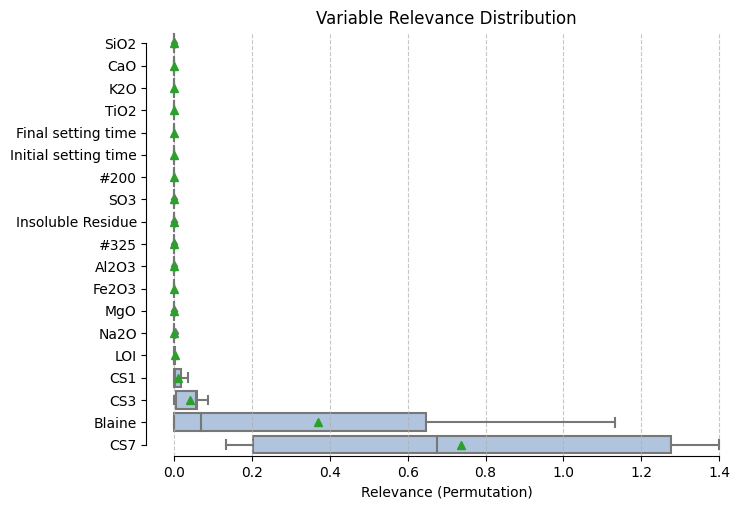

<IPython.core.display.Javascript object>

In [41]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

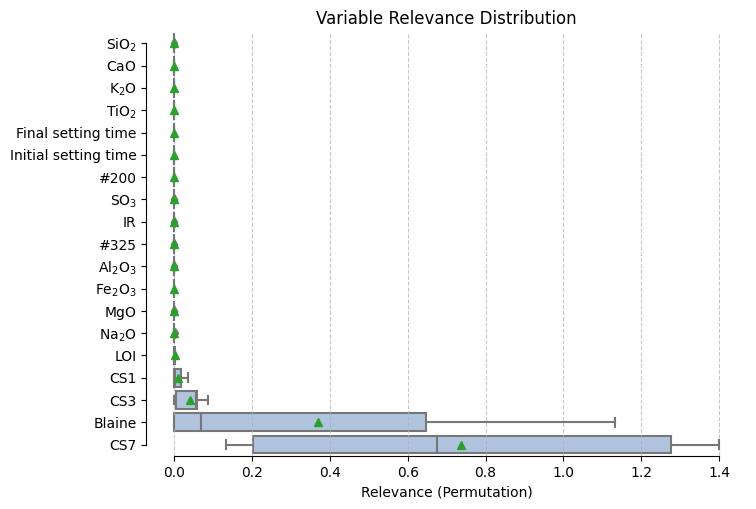

<IPython.core.display.Javascript object>

In [42]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

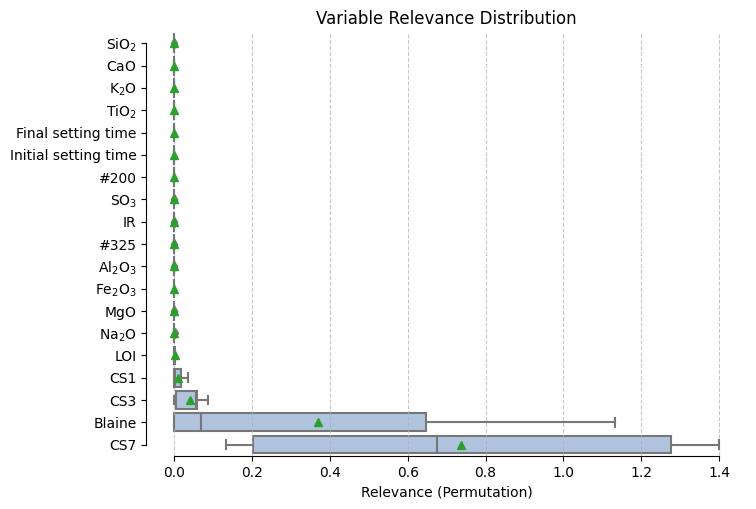

<IPython.core.display.Javascript object>

In [43]:
import matplotlib.ticker as mticker

# Step 1: Define a function to format the x-axis to one decimal place
def one_decimal(x, pos):
    return f'{x:.1f}'

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$"
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

# Step 2: Apply the formatter to the x-axis
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(one_decimal))

plt.savefig(
    "ecics_203_c_cm_p_cs_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()


In [44]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SiO2,5.0,-0.000242,0.000541,-0.001210,0.000000,0.000000,0.000000,0.000000
CaO,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TiO2,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Final setting time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Initial setting time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
#200,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SO3,5.0,0.000004,0.000009,0.000000,0.000000,0.000000,0.000000,0.000020
Insoluble Residue,5.0,0.000020,0.000081,-0.000057,0.000000,0.000000,0.000000,0.000158
#325,5.0,0.000030,0.000068,0.000000,0.000000,0.000000,0.000000,0.000151


<IPython.core.display.Javascript object>

In [45]:
train_data = df_pred[df_pred["SET"] == "TRAIN"]


<IPython.core.display.Javascript object>

In [46]:
train_data[(train_data["CS28"] >= 32) & (train_data["CS28"] <= 38)]["CS28"].describe().T

count    1957.000000
mean       34.489985
std         1.396134
min        32.080000
25%        33.380000
50%        34.150000
75%        35.330000
max        38.000000
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [47]:
train_data[(train_data["CS28"] >= 44) & (train_data["CS28"] <= 48)]["CS28"].describe().T

count    3349.000000
mean       46.670403
std         0.760423
min        45.000000
25%        46.150000
50%        46.700000
75%        47.230000
max        48.000000
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

### Linear Regression - Top model according dominance count SCPM: -4.47 | Dominance Count: 112

In [48]:
# Modeling
from sklearn.linear_model import LinearRegression

<IPython.core.display.Javascript object>

In [49]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

## 1.2. Time Series Cross Validation

In [50]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.935 (0.119)
MAE: -0.723 (0.107)
MAPE: -0.017 (0.002)
R2: 0.975 (0.006)


******
[TEST]
******
RMSE: -1.113 (0.080)
MAE: -0.869 (0.073)
MAPE: -0.021 (0.002)
R2: 0.964 (0.004)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [51]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [52]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2017-08-01 15:36:00,49.03,48.280060,TRAIN,CP II-F40
1,2017-08-02 15:41:00,46.93,47.212217,TRAIN,CP II-F40
2,2017-08-02 15:41:00,33.20,34.453845,TRAIN,CP II-E32
3,2017-08-04 15:41:00,46.80,47.881806,TRAIN,CP II-F40
4,2017-08-04 15:41:00,34.40,34.122175,TRAIN,CP II-E32
...,...,...,...,...,...
2820,2023-03-27 11:00:00,47.06,47.288975,TEST,CP VARI
2821,2023-03-27 11:00:00,33.21,34.415890,TEST,CP II-E32
2822,2023-03-28 11:01:00,33.28,34.666498,TEST,CP II-E32
2823,2023-03-28 11:01:00,47.11,45.729754,TEST,CP II-E40


<IPython.core.display.Javascript object>

In [53]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_linear_regression_btsscv_209_k.xlsx", index=False)
# df_copy_merge.to_csv("local_model_linear_regression_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [54]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

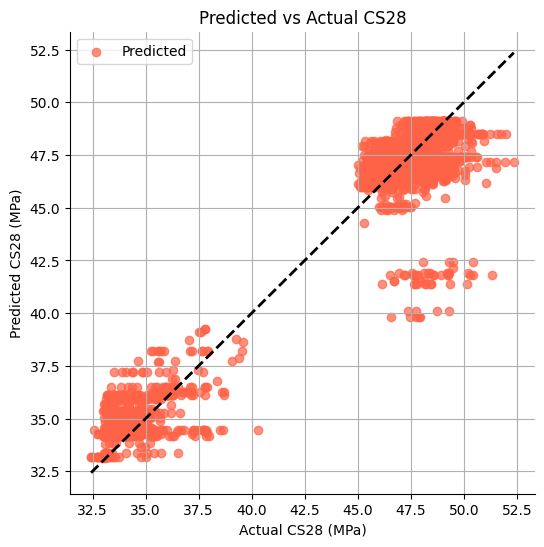

<IPython.core.display.Javascript object>

In [55]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_203_c_cm_p_cs_btiss_dominant_top_one_linear_regression_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


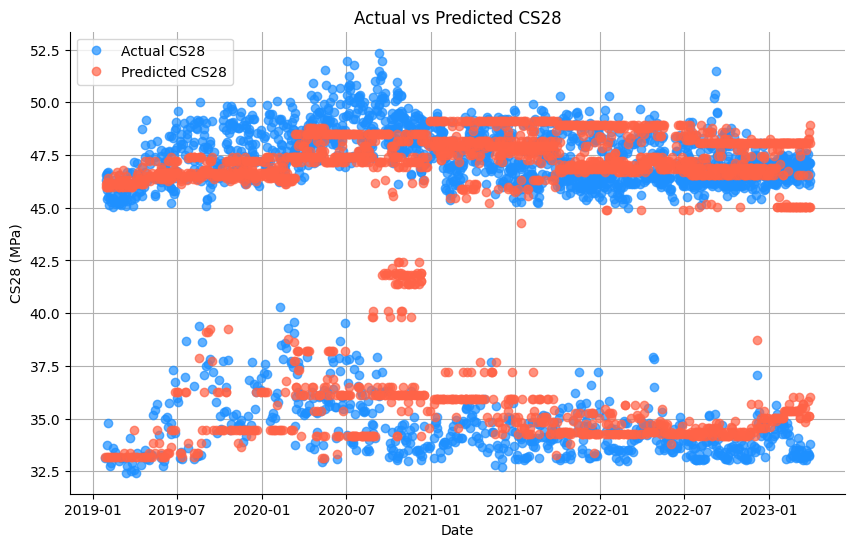

<IPython.core.display.Javascript object>

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_scpm_top_one_linear_regression_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [57]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [58]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Coefficients - 0,0.239200,0.069892,-0.091247,0.780985,-0.711359,0.748594,0.032187,-0.172059,0.193433,-0.148608,-0.437670,0.707643,0.147759,-0.374003,-0.107004,0.038173,0.759973,-0.162549,3.123100
Coefficients - 1,0.038731,0.132347,0.155818,-0.747605,0.538126,0.220559,0.003148,-0.304243,-0.023380,-0.068040,0.021167,0.903440,0.222228,-0.822014,-0.446416,-0.151141,-0.107928,0.606629,2.424137
Coefficients - 2,0.352363,-0.059723,-0.036365,-0.374949,-0.151943,0.063790,-0.205542,0.194237,-0.442214,-0.565426,0.021069,0.357630,0.060639,-1.603894,0.331657,0.393345,-1.206957,3.200992,1.884176
Coefficients - 3,0.037344,-0.009358,-0.083035,0.047958,-0.090852,0.314985,-0.171682,0.174234,-0.394707,0.058065,0.097652,0.632415,0.095443,-0.616493,0.710323,0.042994,0.963443,-0.510774,4.576866
Coefficients - 4,0.207194,0.046448,-0.042152,0.028228,-0.255239,0.196140,-0.040845,-0.024231,-0.076547,0.279806,-0.029955,0.670595,0.309396,-0.802544,0.408160,-0.089537,1.252189,-1.885715,5.110584


<IPython.core.display.Javascript object>

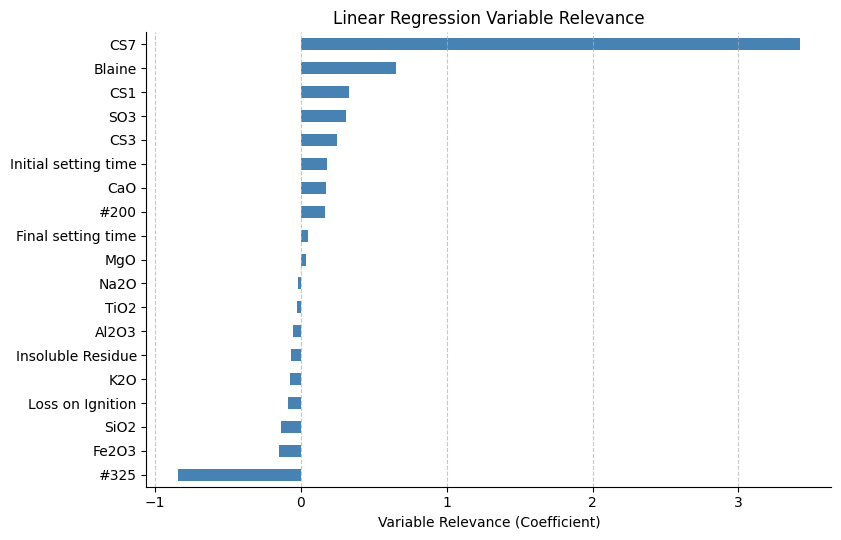

<IPython.core.display.Javascript object>

In [59]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Relevance")
plt.xlabel("Variable Relevance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

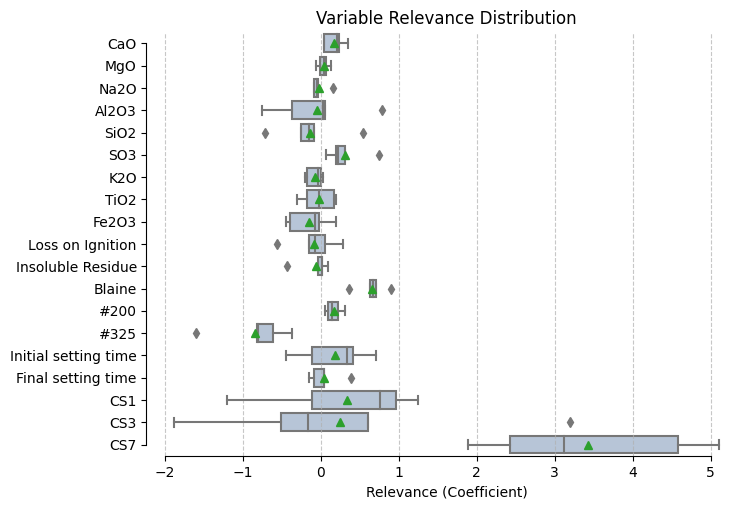

<IPython.core.display.Javascript object>

In [60]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


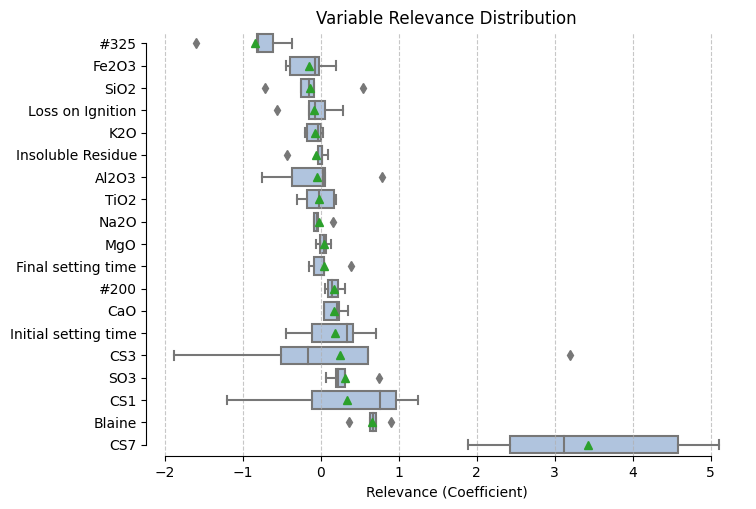

<IPython.core.display.Javascript object>

In [61]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
# df_importances_sorted = df_importances_sorted.rename(
#    columns={"Loss on Ignition": "LOI"}
# )

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_linear_regression_dominant_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [62]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [63]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

In [64]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_linear_regression_dominant_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

<IPython.core.display.Javascript object>

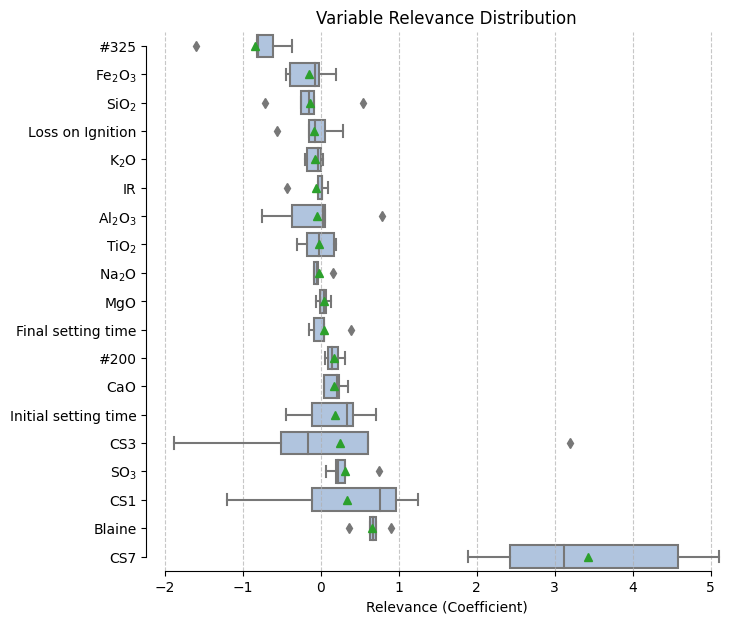

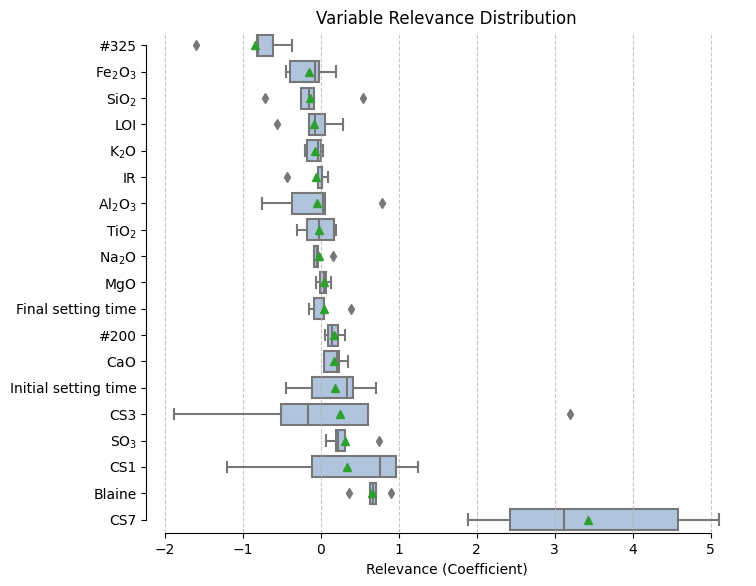

<IPython.core.display.Javascript object>

In [65]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.savefig(
    "ecics_cm_p_cs_btiss_linear_regression_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [66]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#325,Initial setting time,Final setting time,CS1,CS3,CS7
Coefficients - 0,0.239200,0.069892,-0.091247,0.780985,-0.711359,0.748594,0.032187,-0.172059,0.193433,-0.148608,-0.437670,0.707643,0.147759,-0.374003,-0.107004,0.038173,0.759973,-0.162549,3.123100
Coefficients - 1,0.038731,0.132347,0.155818,-0.747605,0.538126,0.220559,0.003148,-0.304243,-0.023380,-0.068040,0.021167,0.903440,0.222228,-0.822014,-0.446416,-0.151141,-0.107928,0.606629,2.424137
Coefficients - 2,0.352363,-0.059723,-0.036365,-0.374949,-0.151943,0.063790,-0.205542,0.194237,-0.442214,-0.565426,0.021069,0.357630,0.060639,-1.603894,0.331657,0.393345,-1.206957,3.200992,1.884176
Coefficients - 3,0.037344,-0.009358,-0.083035,0.047958,-0.090852,0.314985,-0.171682,0.174234,-0.394707,0.058065,0.097652,0.632415,0.095443,-0.616493,0.710323,0.042994,0.963443,-0.510774,4.576866
Coefficients - 4,0.207194,0.046448,-0.042152,0.028228,-0.255239,0.196140,-0.040845,-0.024231,-0.076547,0.279806,-0.029955,0.670595,0.309396,-0.802544,0.408160,-0.089537,1.252189,-1.885715,5.110584


<IPython.core.display.Javascript object>

In [67]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
#325,5.0,-0.843790,0.461600,-1.603894,-0.822014,-0.802544,-0.616493,-0.374003
Fe2O3,5.0,-0.148683,0.266757,-0.442214,-0.394707,-0.076547,-0.023380,0.193433
SiO2,5.0,-0.134253,0.447766,-0.711359,-0.255239,-0.151943,-0.090852,0.538126
Loss on Ignition,5.0,-0.088840,0.311697,-0.565426,-0.148608,-0.068040,0.058065,0.279806
K2O,5.0,-0.076547,0.106230,-0.205542,-0.171682,-0.040845,0.003148,0.032187
Insoluble Residue,5.0,-0.065548,0.212954,-0.437670,-0.029955,0.021069,0.021167,0.097652
Al2O3,5.0,-0.053077,0.569747,-0.747605,-0.374949,0.028228,0.047958,0.780985
TiO2,5.0,-0.026412,0.216421,-0.304243,-0.172059,-0.024231,0.174234,0.194237
Na2O,5.0,-0.019396,0.100894,-0.091247,-0.083035,-0.042152,-0.036365,0.155818
MgO,5.0,0.035921,0.073758,-0.059723,-0.009358,0.046448,0.069892,0.132347


<IPython.core.display.Javascript object>

In [68]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [69]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

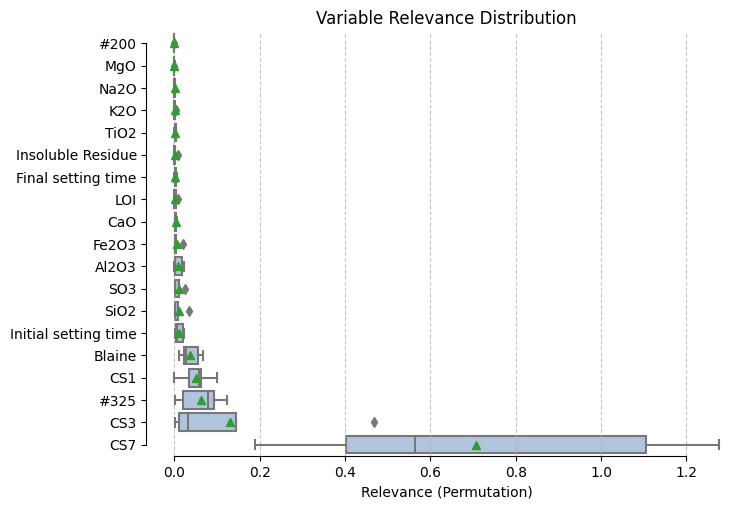

<IPython.core.display.Javascript object>

In [70]:
# Convert lists to DataFrames
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_linear_regression_dominant_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

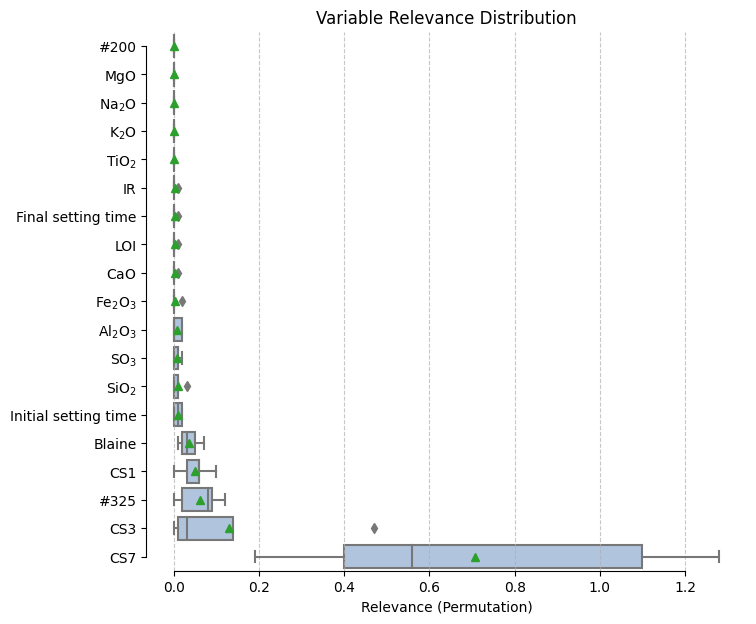

<IPython.core.display.Javascript object>

In [71]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_linear_regression_dominant_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

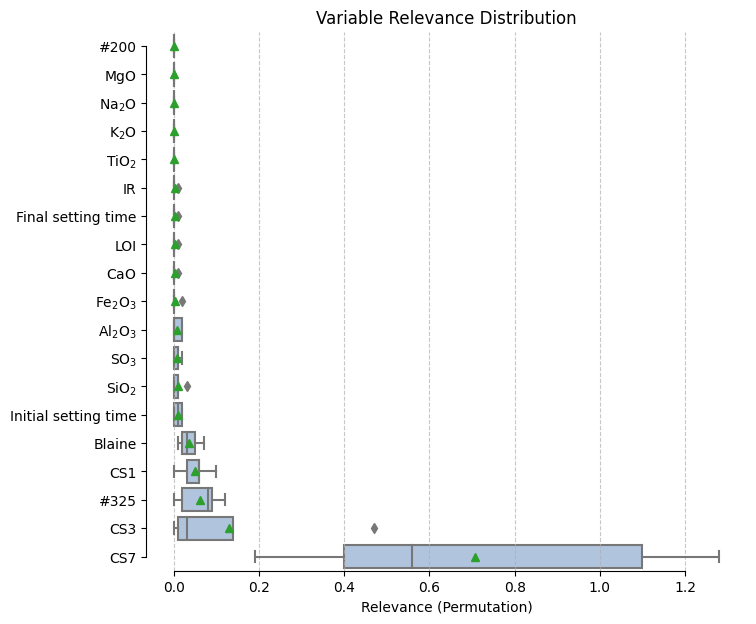

<IPython.core.display.Javascript object>

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "ecics_203_c_cm_p_cs_btiss_linear_regression_dominant_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [73]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
#200,5.0,-0.0004,0.0007,-0.0017,-0.0003,-0.0001,0.0000,0.0001
MgO,5.0,-0.0002,0.0005,-0.0012,-0.0002,-0.0000,0.0000,0.0001
Na2O,5.0,0.0002,0.0006,-0.0003,-0.0002,-0.0001,0.0008,0.0009
K2O,5.0,0.0008,0.0018,-0.0002,-0.0001,0.0000,0.0004,0.0041
TiO2,5.0,0.0018,0.0017,-0.0000,0.0006,0.0014,0.0027,0.0043
Insoluble Residue,5.0,0.0018,0.0042,-0.0005,-0.0001,0.0001,0.0003,0.0094
Final setting time,5.0,0.0020,0.0029,-0.0000,0.0002,0.0003,0.0028,0.0068
LOI,5.0,0.0021,0.0038,-0.0014,-0.0000,0.0005,0.0032,0.0083
CaO,5.0,0.0026,0.0022,0.0004,0.0007,0.0024,0.0039,0.0058
Fe2O3,5.0,0.0050,0.0085,0.0002,0.0002,0.0018,0.0028,0.0200


<IPython.core.display.Javascript object>

In [74]:
perm_importances_df

,#200,MgO,Na2O,K2O,TiO2,Insoluble Residue,Final setting time,LOI,CaO,Fe2O3,Al2O3,SO3,SiO2,Initial setting time,Blaine,CS1,#325,CS3,CS7
0,0.000072,-0.000154,0.000895,-0.000238,0.002721,0.009389,-0.000038,-1.389569e-03,0.003858,0.001836,0.017083,0.024432,0.032936,0.000827,0.023171,0.033426,0.000945,0.001571,0.563471
1,-0.000344,-0.001190,-0.000181,0.000022,0.001449,-0.000054,0.002812,5.447500e-04,0.000701,0.000210,0.021419,0.002279,0.007363,0.020870,0.067165,-0.001203,0.091563,0.032572,0.401698
2,0.000005,0.000150,-0.000253,0.004104,0.004292,0.000083,0.006758,8.296062e-03,0.002383,0.019974,0.001586,0.000448,0.001121,0.006289,0.010041,0.061280,0.122110,0.467335,0.189116
3,-0.000106,-0.000035,-0.000133,-0.000063,0.000567,-0.000480,0.000162,-3.951395e-07,0.000386,0.002770,0.000108,0.009960,0.001728,0.021851,0.027807,0.057671,0.021132,0.010412,1.276840
4,-0.001691,0.000046,0.000793,0.000415,-0.000020,0.000276,0.000254,3.208538e-03,0.005766,0.000153,-0.000229,0.010802,0.008091,0.003727,0.054582,0.100678,0.077935,0.143809,1.104300


<IPython.core.display.Javascript object>